In [46]:
#Импорт библиотек
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as msno
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

## Импорт данных и "предполетная" подготовка

In [47]:
#Импортируем данные

df_train = pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_test = pd.read_csv('test.csv', encoding = 'ISO-8859-1', low_memory = False)

In [48]:
# Чтобы можно было производить обработку всех данных сразу, объединим датасеты в один и 
# пометим бинарными ключами. 
# По этим клшючам потом спокойно разделим его обратно
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['default'] = 0 # мы должны предсказать default, поэтому пока просто заполняем тестовую часть нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

print(df_train.shape)
print(df_test.shape)
print(df.shape)

(73799, 20)
(36349, 20)
(110148, 20)


In [49]:
# Также сразу зафиксируем Random_seed для воспроизводимости экспериментов
RANDOM_SEED = 42 

## Используемые функции и классы

In [50]:
# Класс для работы с выбросами. Умеет выдавать информацию по кол-ву выбросов в стобцах, 
# показывать боксплоты и удалять выбросы. 
# P.S. Изначально в этом классе я просто забыл везде указывать Self, однако он работает и без этого. 
class outliers():
    def find(df): #метод для поиска и вывода информации о выбросах
        print(df.describe())
        for col in df.columns:
            if df[col].dtype != 'O':
                counter = 0
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                for string in df[col]:
                    if (string < (Q1 - 1.5 * IQR) or string > (Q3 + 1.5 * IQR)):
                        counter += 1
                print('количество выбросов в столбце {}'.format(col), '-', counter)
                
    def show(df): #метод для отображения выбросов в виде боксплотов
        fig, axes = plt.subplots(figsize=(40, 20))
        df.boxplot()
        
    def delete(df): #метод для удаления выбросов
        for col in df.columns:
            if df[col].dtype != 'O':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                for string in df[col]:
                    if (string < (Q1 - 1.5 * IQR) or string > (Q3 + 1.5 * IQR)):
                        df = df.drop(df[df[col] == string].index)
        return df

#Функция для превращения признака app_data в набор отдельных признаков:
def extract_datetime_features(df,datetime_col_name='app_date'):
    results = {}
    start = df[datetime_col_name].min()
    results['month'] = df[datetime_col_name].dt.month
    results['day'] = df[datetime_col_name].dt.day
    results['week'] = df[datetime_col_name].dt.week
    results['dayofweek'] = df[datetime_col_name].dt.dayofweek
    results['dayofyear'] = df[datetime_col_name].dt.dayofyear
    results['quarter'] = df[datetime_col_name].dt.quarter
    results['weekofyear'] = df[datetime_col_name].dt.weekofyear
    
    return results

## EDA

#### Просмотр данных, работа над пропусками

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

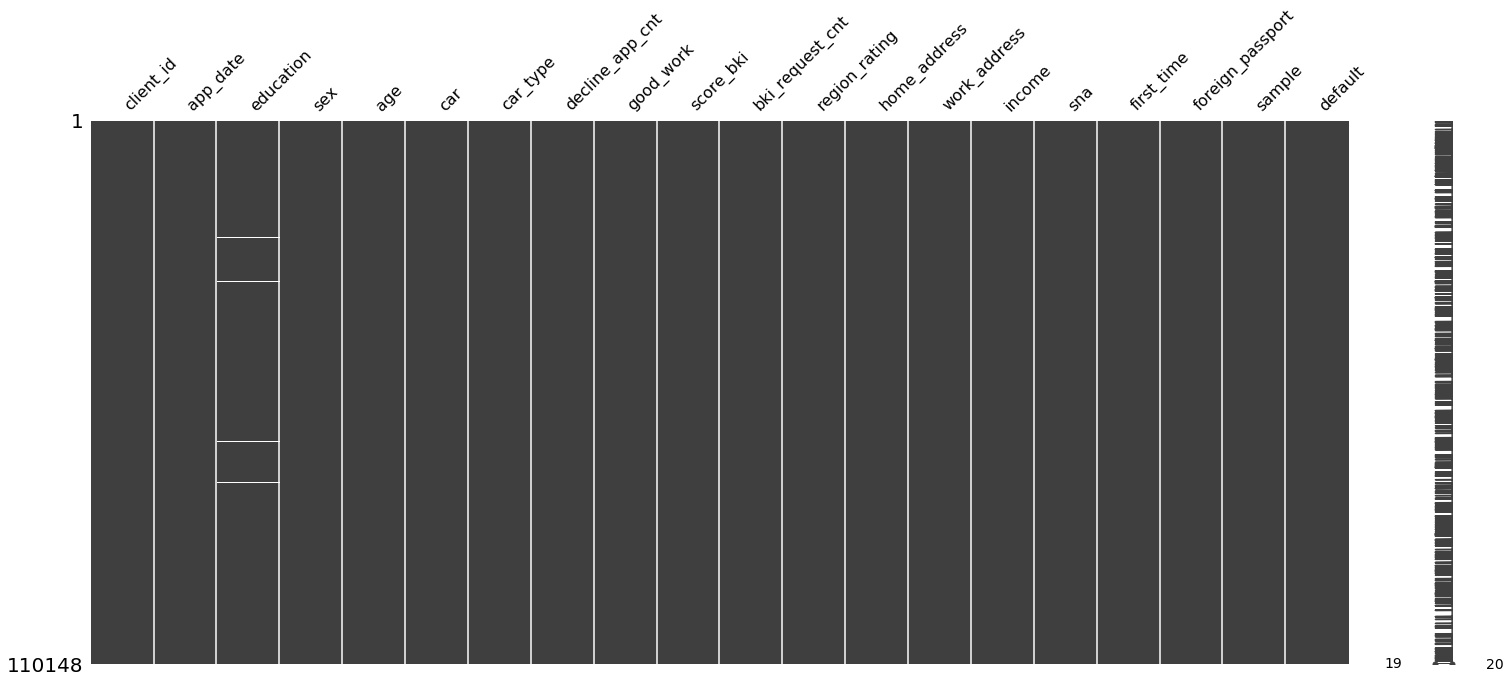

In [51]:
#Теперь посмотрим, есть ли пропущенные значения в данных
display(msno.matrix(df))
display(df.isnull().sum())

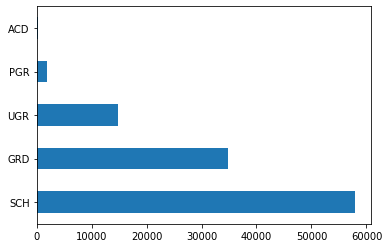

In [52]:
#Как видно,пропусков немного. Они встречаются только в столбце Education. 
#Посмотрим,как распределяются данные в этом столбце чтобы понять, как их обработать.
df['education'].value_counts().plot.barh()

In [53]:
# Судя по диаграммам, можно заполнить пропуски в столбце Education
# самым часто встречюащимся значением, т.е SCH.
df['education'] = df['education'].fillna('SCH')

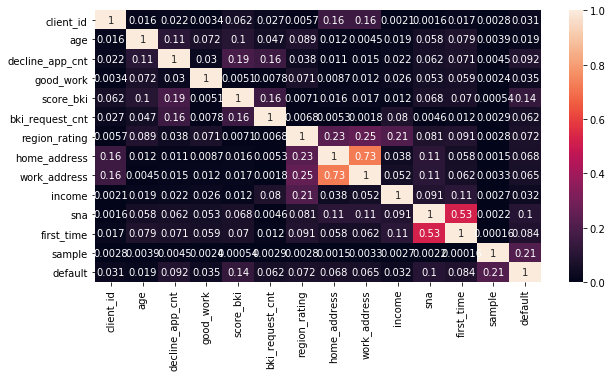

In [54]:
# Также сразу посмотрим, можно ли отбросить какие-то признаки из-за сильной корреляции:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, annot=True)

In [55]:
# work_address и home_address имеют самую высокую степень корреляции. 
# Также сильно скореллированы sna и first_time.
# Удалим work_address. first_time и sna удалять не будем, они важны.

df = df.drop(['work_address'],axis=1)

#### Обработка признака Client_id

In [56]:
# Сразу выделим из тестовых данных признак client_id в отдельную переменную.
# Для клиентских id мы в конечном итоге и будем делать прогноз, а пока из самих датасетов
# его уберем.
clients = df['client_id']
df = df.drop(['client_id'],axis=1)

#### Обработка признака app_date

In [57]:
# В том формате, в котором дата обращения представлена по умолчанию, ничего сделать с ней не плучится.
df['app_date'].head(1)

0    22MAR2014
Name: app_date, dtype: object

In [58]:
#Для этого сначала преобразуем этот признак в формат datetime
df['app_date'] = pd.to_datetime(df['app_date'])

In [59]:
#А затем с помощью функции extract_datetime_features разобьем признак app_date на субпризнаки:
#1) Месяц обращения
#2) День обращения
#3) Неделя обращения
#4) день недели обращения
#5) День года обращения
#6) Квартал
#7) Неделя года обращения
    
for k,v in extract_datetime_features(df).items():
    df[k]=v
df.drop(labels=['app_date'], axis=1, inplace=True)

#### Разбиение признаков по группам.

In [60]:
df

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,foreign_passport,sample,default,month,day,week,dayofweek,dayofyear,quarter,weekofyear
0,GRD,M,29,Y,Y,0,0,-2.271884,3,50,...,N,0,0,3,22,12,5,81,1,12
1,SCH,F,39,N,N,5,0,-1.504999,2,50,...,N,0,0,1,24,4,4,24,1,4
2,UGR,M,50,Y,Y,0,0,-1.691339,1,50,...,Y,0,0,3,23,12,6,82,1,12
3,SCH,M,56,N,N,0,0,-2.374182,1,40,...,N,0,0,2,3,6,0,34,1,6
4,GRD,F,38,N,N,0,0,-2.487502,0,80,...,N,0,0,2,4,6,1,35,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,GRD,F,45,N,N,0,0,-1.792064,3,50,...,N,1,0,3,4,10,1,63,1,10
110144,SCH,M,41,Y,Y,0,0,-2.058029,1,50,...,N,1,0,3,24,13,0,83,1,13
110145,SCH,M,31,N,N,0,0,-1.512635,4,80,...,N,1,0,4,22,17,1,112,2,17
110146,SCH,F,29,N,N,0,1,-1.479334,3,50,...,N,1,1,1,4,1,5,4,1,1


In [61]:
#Разобьем переменные по группам
bin_cols = ['sex','car','car_type','good_work','foreign_passport']
cat_cols = ['education','home_address']
num_cols = ['age','decline_app_cnt','income','bki_request_cnt']

#Признаки, получившиеся в результате преобразования даты, выделим в отдельную категорию
date_cols = ['month','day','week','dayofweek','dayofyear','quarter','weekofyear'] 

#### Обработка бинарных признаков

In [62]:
#Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

# то же самое сделаем для признака education
df['education'] = label_encoder.fit_transform(df['education'])
# убедимся в преобразовании    
df.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,foreign_passport,sample,default,month,day,week,dayofweek,dayofyear,quarter,weekofyear
0,1,1,29,1,1,0,0,-2.271884,3,50,...,0,0,0,3,22,12,5,81,1,12
1,3,0,39,0,0,5,0,-1.504999,2,50,...,0,0,0,1,24,4,4,24,1,4
2,4,1,50,1,1,0,0,-1.691339,1,50,...,1,0,0,3,23,12,6,82,1,12
3,3,1,56,0,0,0,0,-2.374182,1,40,...,0,0,0,2,3,6,0,34,1,6
4,1,0,38,0,0,0,0,-2.487502,0,80,...,0,0,0,2,4,6,1,35,1,6


#### Обработка категориальных признаков

In [63]:
#Категориальные признаки можно просто преобразовать в Dummies
df = pd.get_dummies(df,columns=['education','home_address'])

#### Обработка числовых признаков

Text(0.5, 1.0, 'количество запросов в БКИ')

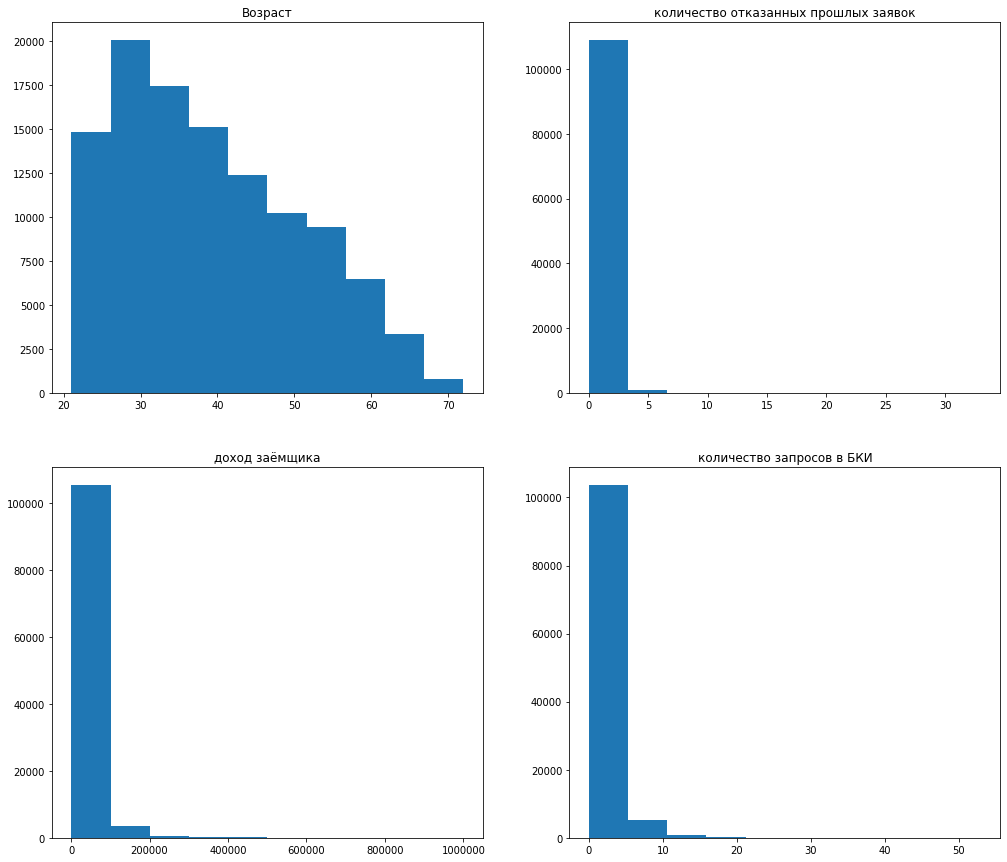

In [64]:
# Cмотрим на распределения числовых признаков в данных. 

fig, axes = plt.subplots(2, 2, figsize=(17, 15))
 
axes[0][0].hist(df['age'])
axes[0][0].set_title('Возраст')

axes[0][1].hist(df['decline_app_cnt'])
axes[0][1].set_title('количество отказанных прошлых заявок')

axes[1][0].hist(df['income'])
axes[1][0].set_title('доход заёмщика')

axes[1][1].hist(df['bki_request_cnt'])
axes[1][1].set_title('количество запросов в БКИ')


In [65]:
# Из гистограмм выше кажется, что выбросы есть, но их немного. 
# Однако я написал класс, который покажет более точную информацию.
outliers.find(df[num_cols])

                 age  decline_app_cnt          income  bki_request_cnt
count  110148.000000    110148.000000   110148.000000    110148.000000
mean       39.249410         0.273205    41012.648537         2.005002
std        11.518063         0.799099    45399.735051         2.266926
min        21.000000         0.000000     1000.000000         0.000000
25%        30.000000         0.000000    20000.000000         0.000000
50%        37.000000         0.000000    30000.000000         1.000000
75%        48.000000         0.000000    48000.000000         3.000000
max        72.000000        33.000000  1000000.000000        53.000000
количество выбросов в столбце age - 0
количество выбросов в столбце decline_app_cnt - 18677
количество выбросов в столбце income - 7000
количество выбросов в столбце bki_request_cnt - 2636


In [66]:
# Если судить по цифрам, то выбросов везде, кроме age, оказывается весьма ощутимое количество. 
# В общей сумме это больше четверти всего датасета. Попробуем поискать выбросы в тех же данных, 
# но логарифмированных.
outliers.find(np.log(df[num_cols]+1))

                 age  decline_app_cnt         income  bki_request_cnt
count  110148.000000    110148.000000  110148.000000    110148.000000
mean        3.654546         0.151330      10.345792         0.878752
std         0.285054         0.361331       0.696636         0.658667
min         3.091042         0.000000       6.908755         0.000000
25%         3.433987         0.000000       9.903538         0.000000
50%         3.637586         0.000000      10.308986         0.693147
75%         3.891820         0.000000      10.778977         1.386294
max         4.290459         3.526361      13.815512         3.988984
количество выбросов в столбце age - 0
количество выбросов в столбце decline_app_cnt - 18677
количество выбросов в столбце income - 2609
количество выбросов в столбце bki_request_cnt - 15


In [67]:
# Ситуация стала получше везде, кроме признака decline_app_cnt. Попробуем оставить это как есть 
# и логарифмируем все признаки
df['age'] = np.log(df['age']+1)
df['bki_request_cnt'] = np.log(df['bki_request_cnt']+1)
df['income'] = np.log(df['income']+1)
df['decline_app_cnt'] = np.log(df['decline_app_cnt']+1)


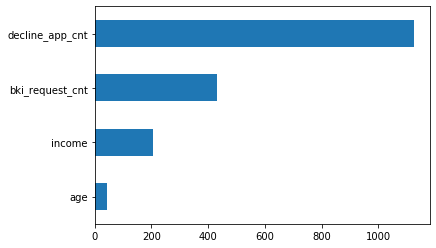

In [68]:
# Оценим важность числовых признаков
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

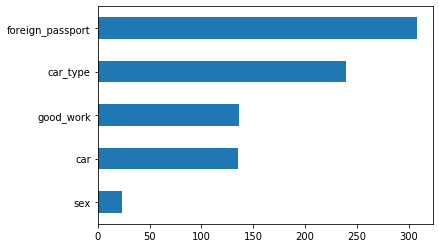

In [69]:
# Оценим важность бинарных признаков
imp_num = Series(f_classif(df[bin_cols], df['default'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

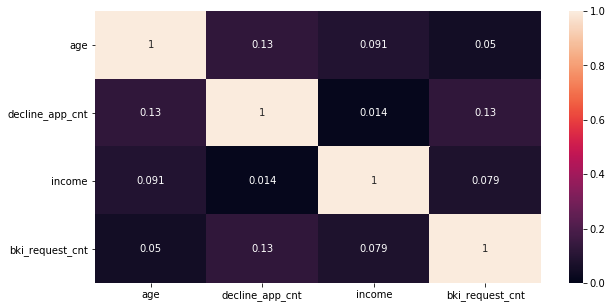

In [70]:
# Самый значительный - decline_app_cnt
# Теперь посмотрим матрицу корреляци для числовых признаков.
plt.figure(figsize=(10,5))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

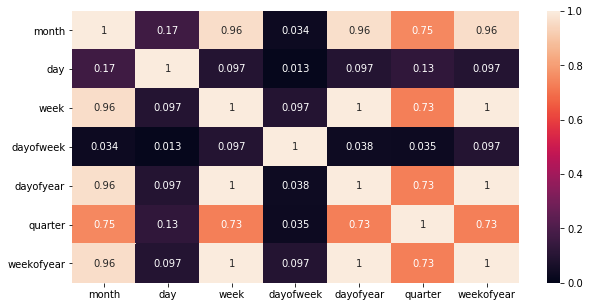

In [71]:
# Явных корреляций здесь нет.Теперь посмотрим корреляции признаков дат
plt.figure(figsize=(10,5))
sns.heatmap(df[date_cols].corr().abs(), vmin=0, vmax=1, annot=True)

In [72]:
# Явно видно, что с признаками дат мы переборщили. Уберем weekofyear, quarter, dayofyear:
df = df.drop(['weekofyear'],axis=1)
df = df.drop(['quarter'],axis=1)
df = df.drop(['dayofyear'],axis=1)

In [73]:
# Атуализируем группы
bin_cols = ['sex','car','car_type','good_work','foreign_passport']
cat_cols = ['home_address']
num_cols = ['age','decline_app_cnt','income','bki_request_cnt']

# Признаки, получившиеся в результате преобразования даты, выделим в отдельную категорию
date_cols = ['month','day','week','dayofweek'] 

### Подготовка модели

In [74]:
# Прежде всего вернем в датасет признак ClientID:

df['client_id'] = clients

In [75]:
# Разделим датасет обратно на тестовые и тренировочные данные. 
# Обучение и тестирование модели будет производиться на тренировочных данных. 
# Из тестового датасета отдельно сохраним данные с клиентскими id

df_train = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)
df_test = df.query('sample == 0').drop(['sample', 'default'], axis=1)

y = df_train.default.values           
X = df_train.drop(['default'], axis=1).values

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
df_test.shape, df_train.shape, X.shape, X_train.shape, X_valid.shape

((36349, 26), (73799, 26), (73799, 25), (59039, 25), (14760, 25))

In [77]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

In [78]:
# Метрики качества
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
value = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), recall_score(y_valid,y_pred),
         f1_score(y_valid,y_pred)]
first_metrics_df = pd.DataFrame({'Метрика': metrics, 'Значение': value}, columns=['Метрика', 'Значение'])

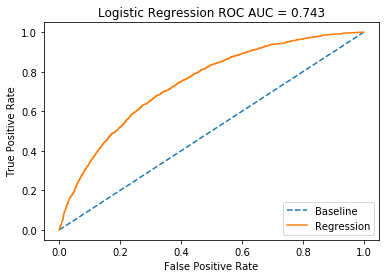

In [79]:
#Кривая ROC-AUC
fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
roc_auc = roc_auc_score(y_valid, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [80]:
# Матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

41 66
1786 12867


In [81]:
# Хотя ROC-AUC дал неплохой результат, мы абсолютно не угадали дефолтных клиентов. 
# Посмотрим на PRC-AUC, поскольку данная метрика может оценивать эффективность алгоритма на несбалансированных данных
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)

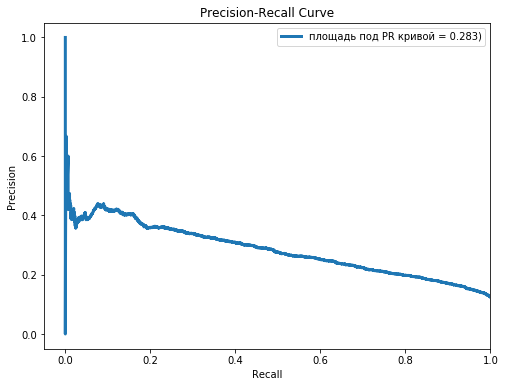

In [82]:
plt.figure(figsize=(8, 6))
prc_area = auc(recall, precision)
plt.plot(recall, precision, lw=3, label='площадь под PR кривой = %0.3f)' % prc_area)
    
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


In [83]:
# Добавим метрики в наш датасет метрик для первой модели

add_metrics = pd.DataFrame({'Метрика': ['ROC_AUC', 'PRC_AUC'], 'Значение':
                            [roc_auc, prc_area]}, columns=['Метрика', 'Значение'])

first_metrics_df = first_metrics_df.append(add_metrics, ignore_index=True)

In [84]:
first_metrics_df

,Метрика,Значение
0,accuracy,0.874526
1,precision,0.383178
2,recall,0.022441
3,f1_score,0.042399
4,ROC_AUC,0.743081
5,PRC_AUC,0.282590


### Улучшение характеристик модели

В предыдущей модлели мы получили f1_score = 0.038 recall = 0.022.В данном случае метрика ROC-AUC (= 0.743) не показательна, поскольку мы имеем дело с несбалансированной моделью.
Попробуем подобрать параметры вручную.


In [85]:
model = LogisticRegression(random_state=RANDOM_SEED)

iter_max = 100

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

E:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.33981291        nan
 0.33981291        nan 0.05606898 0.05630384        nan 0.05484849
 0.05390393 0.05606898 0.05630384        nan 0.05484849 0.05390393
 0.34033416 0.33733227 0.34027855 0.33992432 0.33941233 0.34033416
 0.33733227 0.34027855 0.33992432 0.33941233 0.05654685 0.05437491
 0.05483553 0.0541444  0.05654685 0.05437491 0.05483553 0.0541444
 0.33997932 0.33785653 0.33971004 0.33945693 0.33997932 0.33785653
 0.33971004 0.33945693]
  category=UserWarning


LogisticRegression(class_weight='balanced', random_state=42, solver='newton-cg')


In [86]:
# Обучим модель на данных и проверим confusion_matrix

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

In [87]:
# матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

1250 4230
577 8703


In [88]:
print('Accuracy: %.4f' % accuracy_score(y_valid, y_pred))
print('Precision: %.4f' % precision_score(y_valid, y_pred))
print('Recall: %.4f' % recall_score(y_valid, y_pred))
print('F1: %.4f' % f1_score(y_valid, y_pred))

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 4))
print('PRC_AUC = ', round(auc(recall, precision), 4))

Accuracy: 0.6743
Precision: 0.2281
Recall: 0.6842
F1: 0.3421
ROC_AUC =  0.7428
PRC_AUC =  0.2819


In [89]:
# Метрики первой модели
first_metrics_df

,Метрика,Значение
0,accuracy,0.874526
1,precision,0.383178
2,recall,0.022441
3,f1_score,0.042399
4,ROC_AUC,0.743081
5,PRC_AUC,0.282590


### Итог

Изначально данные были плохо сбалансированы, и строить адекватных прогнозов по ним не получалось. 
Однако, с помощью GridSearchCV удалось найти такие параметры модели, которые серьезно улучшили F-меру.
При более тщательных и долгих экспериментах с поиском параметров наверняка можно добиться улучшения и остальных метрик.